In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load the correct matplotlibrc
import os
mpl.rc_file(os.path.join('..', 'matplotlibrc'))
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"""
    \usepackage{siunitx}
    \usepackage{libertine}
    \usepackage{libertinust1math}
    \renewcommand*\familydefault{\sfdefault}
    \renewcommand{\vec}[1]{\mathbf{#1}}
    \newcommand{\mat}[1]{\mathbf{#1}}
"""
mpl.rcParams["figure.dpi"] = 200

import sys
sys.path.append('../../code/lib')
import lif_utils

In [3]:
def sample_neuron_activities_for_xs(xs, gain, bias, sigma=1, N_smpls=100000):
    Js = gain * xs[:, None] + bias + np.random.normal(0, sigma, N_smpls)[None, :]
    As = lif_utils.lif_rate(Js, tau_rc=100e-3, tau_ref=10e-3)
    return As

In [4]:
def compute_density(Ass, N_bins=50, b0=0, b1=50):
    pss = np.zeros((Ass.shape[0], N_bins))
    for i in range(Ass.shape[0]):
        pss[i], bins = np.histogram(Ass[i],
                                    N_bins,
                                    range=(b0, b1),
                                    density=True)
    return pss, bins

In [5]:
def plot_density(ax, density, xs, ys_bins, colour="tab:blue", levels=[-1.5, 0], min_alpha=0.25, max_alpha=0.5):
    ys_bins_stretched = np.linspace(ys_bins[0], ys_bins[-1], density.shape[1])
    log_density = np.log10(density+1e-9).T
    colour = np.array(mpl.colors.to_rgb(colour))
    for i, (l0, l1) in enumerate(zip(levels[:-1], levels[1:])):
        alpha = np.linspace(min_alpha, max_alpha, len(levels) - 1)[i]
        colour_with_alpha = np.concatenate((colour, (alpha,)))
        cnt = ax.contourf(xs, ys_bins_stretched, log_density, levels=[l0, l1], colors=[colour_with_alpha])

In [114]:
def compute_decoding_density(xs, Ass, N_smpls=1000):
    # Make sure the activitiy inputs are a numpy array
    Ass = np.asarray(Ass)
    if Ass.ndim == 2:
        Ass = Ass.reshape((1, *Ass.shape))

    # Fetch and check some dimensionalities
    N_neurons = Ass.shape[0]
    N_x = len(xs)
    N_smpls_orig = Ass.shape[2]
    assert(Ass.shape[1] == N_x)

    # Compute the underlying probability densities
    ps = [None] * N_neurons
    for i in range(N_neurons):
        ps[i], bins = compute_density(Ass[i])
    ps = np.asarray(ps)
    N_bins = len(bins) - 1

    # Sample N_smpls activities for each xs
    smpls = np.zeros((N_x, N_smpls, N_neurons))
    idcs = np.random.randint(0, N_smpls_orig, (N_smpls, N_neurons))
    for i in range(N_neurons):
        smpls[:, :, i] = Ass[i, :, idcs[:, i]].T

    # For each sample, compute the maximum-likelihood x
    Xss = np.zeros((N_x, N_smpls))
    bins_bool = np.logical_and(
        smpls[:, :, :] >= bins[:-1, None, None, None],
        smpls[:, :, :] < bins[1:, None, None, None])
    bin_idcs = np.argmax(bins_bool, axis=0)
    for i in range(N_smpls):
        for j in range(N_x):
            # Compute the likelihood
            Ps = np.zeros((N_x,))
            for k in range(N_neurons):
                Ps += np.log10(ps[k, :, bin_idcs[j, i, k,]] + 1e-9)

            # If there are multiple instances with the same likeli
            idx = np.random.choice((np.where(Ps == np.max(Ps))[0]))
            Xss[j, i] = xs[idx]

    return Xss

In [143]:
xs = np.linspace(-1, 1, 101)
Ass1 = sample_neuron_activities_for_xs(xs, 8.0, 1.0)
Ass2 = sample_neuron_activities_for_xs(xs, -8.0, 1.0)
Ass3 = sample_neuron_activities_for_xs(xs, -4.0, 5.0)
Ass4 = sample_neuron_activities_for_xs(xs, 2.0, 3.0)
Ass5 = sample_neuron_activities_for_xs(xs, -10.0, -1.0)
Ass6 = sample_neuron_activities_for_xs(xs, 10.0, -2.0)

In [144]:
def plot_tuning_curve_and_decoding(ax1, ax2, xs, Ass, show_titles=True, letter="A"):
    # Make sure the activitiy inputs are a numpy array
    Ass = np.asarray(Ass)
    if Ass.ndim == 2:
        Ass = Ass.reshape((1, *Ass.shape))

    # Colours to use for the individual neurons    
    colours = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:red", "tab:cyan"]
    for i in range(Ass.shape[0]):
        density, ys_bins = compute_density(Ass[i])
        colour = colours[i]
        plot_density(ax1, density, xs, ys_bins, colour=colour)
        ax1.plot(xs, np.median(Ass[i], axis=1), color=colour, zorder=1)

    ax1.set_xlabel('Represented value $x$')
    ax1.set_ylabel('Activity $a$ ($\\mathrm{s}^{-1})$')

    # Compute the decoding
    Xss = compute_decoding_density(xs, Ass)
    err = np.sqrt(np.mean(np.square(Xss - xs[:, None])))
    density, ys_bins = compute_density(Xss, N_bins=21, b0=xs[0], b1=xs[-1])
    plot_density(ax2, density, xs, ys_bins, levels=[0, 1], colour='k')
    ax2.plot(xs, np.median(Xss, axis=1), 'k')
    ax2.plot([-1, 1], [-1, 1], 'k', linewidth=0.75)
    ax2.plot([-1, 1], [-1, 1], ':', color='white', linewidth=0.75)
    ax2.set_ylabel('Decoded value $\\hat x$')
    ax2.set_xlabel('Represented value $x$')

    if show_titles:
        ax1.set_title('Tuning curves')
        ax2.set_title('Decoding')

    ax2.text(-0.9, 0.9, "$E = {:0.2f}$".format(err), va="top", ha="left")

    ax1.text(-0.23,
              1.046,
              f'\\textbf{{{letter}}}',
              va="bottom",
              ha="right",
              fontdict={"size": 12},
              transform=ax1.transAxes)

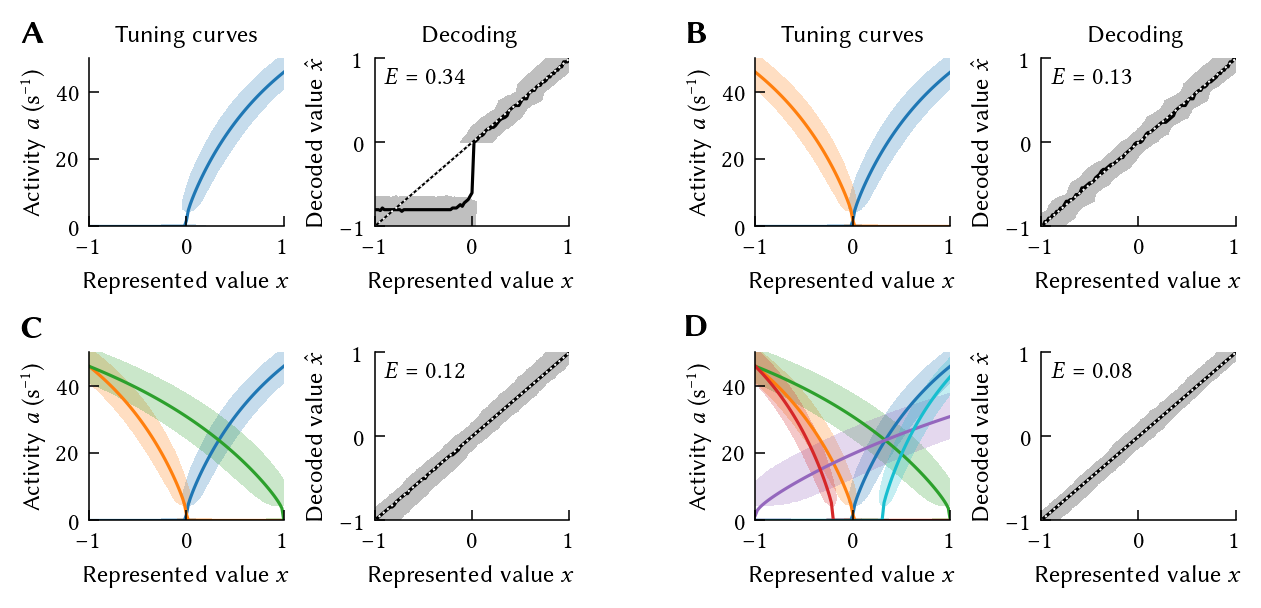

In [145]:
fig = plt.figure(figsize=(7.4, 3.5))
gs = mpl.gridspec.GridSpec(2, 13, wspace=20.0, hspace=0.75)
ax11 = fig.add_subplot(gs[0, 0:3])
ax12 = fig.add_subplot(gs[0, 3:6])
ax21 = fig.add_subplot(gs[0, 7:10])
ax22 = fig.add_subplot(gs[0, 10:13])
ax31 = fig.add_subplot(gs[1, 0:3])
ax32 = fig.add_subplot(gs[1, 3:6])
ax41 = fig.add_subplot(gs[1, 7:10])
ax42 = fig.add_subplot(gs[1, 10:13])

plot_tuning_curve_and_decoding(ax11, ax12, xs, [Ass1], letter="A")
plot_tuning_curve_and_decoding(ax21, ax22, xs, [Ass1, Ass2], letter="B")
plot_tuning_curve_and_decoding(ax31, ax32, xs, [Ass1, Ass2, Ass3], show_titles=False, letter="C")
plot_tuning_curve_and_decoding(ax41, ax42, xs, [Ass1, Ass2, Ass3, Ass4, Ass5, Ass6], show_titles=False, letter="D")